# Training L63 Parameters with Enzyme: Recovering œÅ

**Goal:** Estimate Lorenz-63 parameter œÅ by differentiating through the time integrator using Enzyme and minimizing trajectory-matching loss.

In [43]:
#import Pkg; Pkg.add("StatsPlots")
using LinearAlgebra, Printf
using LorenzParameterEstimation
using Plots, StatsPlots, Images, FileIO

In [44]:
println("\n================ Package Setup ================")
true_params_classic = classic_params()              # (œÉ,œÅ,Œ≤) = (10,28,8/3)
true_params_stable  = stable_params()               # (10,15,8/3)
true_params_highœÅ   = L63Parameters(10.0, 35.0, 8.0/3.0)
true_params_lowœÅ    = L63Parameters(10.0, 8.0, 8.0/3.0)

# Initial condition (use explicit vector to avoid relying on non-exported utils)
u0 = [1.0, 1.0, 1.0]
M  = 20_000
T  = 100.0
dt = T / M

# Integrate all parameter sets (returns L63Solution)
sol_classic  = integrate(true_params_classic, u0, (0.0, T), dt)
sol_stable   = integrate(true_params_stable,  u0, (0.0, T), dt)
sol_highœÅ    = integrate(true_params_highœÅ,   u0, (0.0, T), dt)
sol_lowœÅ     = integrate(true_params_lowœÅ,    u0, (0.0, T), dt)

println("Classic Lorenz (œÅ=28.0) final state: ", sol_classic.final_state)
println("Original setup (œÅ=15.0) final state: ", sol_stable.final_state)
println("High œÅ (œÅ=35.0) final state: ", sol_highœÅ.final_state)
println("Low œÅ (œÅ=8.0) final state: ", sol_lowœÅ.final_state)


================ Package Setup ================
Classic Lorenz (œÅ=28.0) final state: [-1.0388569689855993, -1.9396559790447456, 16.750658939956015]
Original setup (œÅ=15.0) final state: [-6.110100926607796, -6.110100926607805, 13.999999999999996]
High œÅ (œÅ=35.0) final state: [7.749175013315787, 10.233427645262202, 27.860777856065084]
Low œÅ (œÅ=8.0) final state: [4.320493798938567, 4.320493798938558, 6.999999999999997]


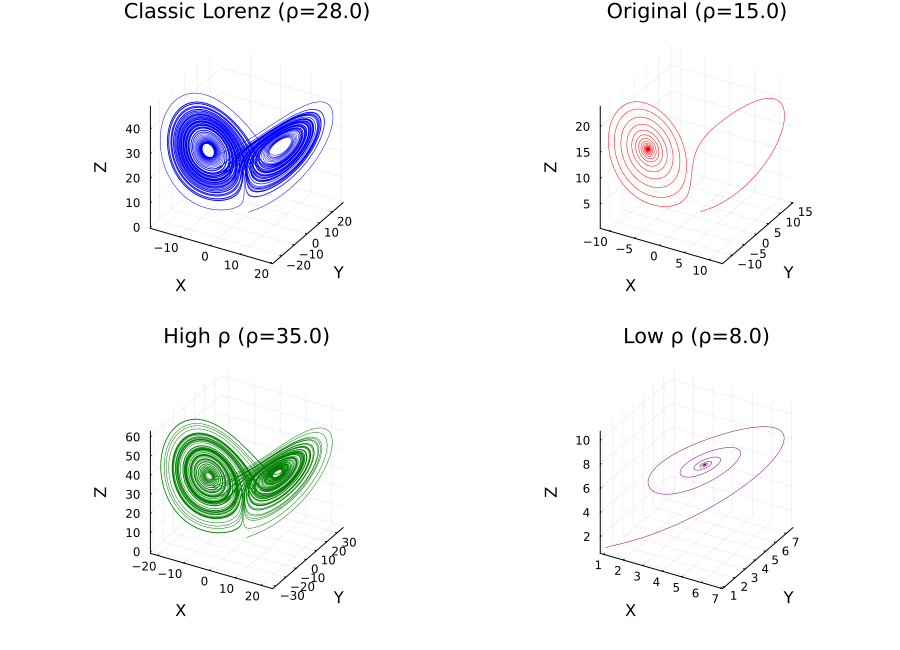

In [45]:
# 3D comparisons similar to the original script
kwargs3d = (; legend=false, linewidth=0.5, seriestype=:path3d)
p1 = plot(sol_classic.u[:, 1], sol_classic.u[:, 2], sol_classic.u[:, 3];
            title="Classic Lorenz (œÅ=28.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:blue, kwargs3d...)
p2 = plot(sol_stable.u[:, 1], sol_stable.u[:, 2], sol_stable.u[:, 3];
            title="Original (œÅ=15.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:red, kwargs3d...)
p3 = plot(sol_highœÅ.u[:, 1], sol_highœÅ.u[:, 2], sol_highœÅ.u[:, 3];
            title="High œÅ (œÅ=35.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:green, kwargs3d...)
p4 = plot(sol_lowœÅ.u[:, 1], sol_lowœÅ.u[:, 2], sol_lowœÅ.u[:, 3];
            title="Low œÅ (œÅ=8.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:purple, kwargs3d...)
plot(p1, p2, p3, p4, layout=(2,2), size=(900,650))

In [46]:
println("\n================ Sanity Checks ================")
# Test configuration
test_params = true_params_classic
test_system = L63System(params=test_params, u0=u0, tspan=(0.0, 1.0), dt=0.01)
test_sol    = integrate(test_system)

println("\n1. LOSS FUNCTION VALIDATION")
println(repeat("-", 40))

# 1a: Self-consistency (loss with true parameters ~ 0 over a short window)
test_window = 100
self_loss = compute_loss(test_params, test_sol, 1, test_window)
@printf("Self-consistency test: %.2e (expected: ~0)\n", self_loss)
@assert self_loss < 1e-12 "Self-consistency failed: loss should be near machine precision"

# 1b: Sensitivity (loss increases with parameter perturbation)
perturbed = L63Parameters(test_params.œÉ, test_params.œÅ + 0.5, test_params.Œ≤)
perturbed_loss = compute_loss(perturbed, test_sol, 1, test_window)
@printf("Parameter sensitivity test: %.6f (expected: > 0)\n", perturbed_loss)
@assert perturbed_loss > 1e-6 "Sensitivity test failed: loss should increase with parameter perturbation"
println("‚úì Loss function tests passed")

println("\n2. GRADIENT COMPUTATION VALIDATION")
println(repeat("-", 40))

# 2a: Gradients at true parameters (should be small)
loss_val, grad = compute_gradients(test_params, test_sol, 1, test_window)
@printf("Gradients at true parameters (loss=%.2e):\n", loss_val)
@printf("  ‚àÇL/‚àÇœÉ = %+.6e\n", grad.œÉ)
@printf("  ‚àÇL/‚àÇœÅ = %+.6e\n", grad.œÅ)
@printf("  ‚àÇL/‚àÇŒ≤ = %+.6e\n", grad.Œ≤)
grad_norm = norm(grad)
@printf("  ||‚àáL|| = %.6e (expected: small)\n", grad_norm)

# 2b: Gradients at perturbed parameters (should be non-trivial)
loss_val_pert, grad_pert = compute_gradients(perturbed, test_sol, 1, test_window)
@printf("\nGradients at perturbed parameters (loss=%.6f):\n", loss_val_pert)
@printf("  ‚àÇL/‚àÇœÉ = %+.6e\n", grad_pert.œÉ)
@printf("  ‚àÇL/‚àÇœÅ = %+.6e\n", grad_pert.œÅ)
@printf("  ‚àÇL/‚àÇŒ≤ = %+.6e\n", grad_pert.Œ≤)
grad_norm_pert = norm(grad_pert)
@printf("  ||‚àáL|| = %.6e (expected: non-trivial)\n", grad_norm_pert)
@assert grad_norm_pert > 1e-6 "Gradient test failed: gradients should be non-trivial at perturbed parameters"
println("‚úì Gradient computation tests passed")

println("\n3. TRAINING ALGORITHM VALIDATION")
println(repeat("-", 40))

# Generate training data
true_params_train = true_params_classic
train_sol = integrate(true_params_train, u0, (0.0, 10.0), 10.0/2000)

# Initialize with incorrect parameters (œÅ error)
initial_guess = L63Parameters(10.0, 20.0, 8.0/3.0)
@printf("Parameter estimation test:\n")
@printf("  True œÅ:    %.3f\n", true_params_train.œÅ)
@printf("  Initial œÅ: %.3f (error: %.3f)\n", initial_guess.œÅ, abs(initial_guess.œÅ - true_params_train.œÅ))

# Training config ‚Äî match the earlier structure
config = L63TrainingConfig(
    epochs=30,
    Œ∑=1e-2,
    window_size=200,
    clip_norm=5.0,
    update_œÉ=false,
    update_œÅ=true,
    update_Œ≤=false,
    verbose=true
)

@printf("Running training for %d epochs...\n", config.epochs)
best_params, loss_hist, param_hist = train!(initial_guess, train_sol, config)

final_error = abs(best_params.œÅ - true_params_train.œÅ)
# Fix: Access the .train field from the NamedTuple metrics
improvement_ratio = loss_hist[1].train / loss_hist[end].train

@printf("\nTraining results:\n")
@printf("  Final œÅ:        %.6f\n", best_params.œÅ)
@printf("  Parameter error: %.6f ‚Üí %.6f (%.1fx reduction)\n",
        abs(initial_guess.œÅ - true_params_train.œÅ), final_error,
        abs(initial_guess.œÅ - true_params_train.œÅ) / max(final_error, eps()))
@printf("  Loss reduction:  %.6f ‚Üí %.6f (%.1fx improvement)\n",
        loss_hist[1].train, loss_hist[end].train, improvement_ratio)

@assert final_error < abs(initial_guess.œÅ - true_params_train.œÅ) "Training failed: parameter error did not decrease"
#@assert improvement_ratio > 2.0 "Training failed: insufficient loss reduction"
println("‚úì Training algorithm tests passed")


================ Sanity Checks ================

1. LOSS FUNCTION VALIDATION
----------------------------------------
Self-consistency test: 0.00e+00 (expected: ~0)
Parameter sensitivity test: 0.515222 (expected: > 0)
‚úì Loss function tests passed

2. GRADIENT COMPUTATION VALIDATION
----------------------------------------
Gradients at true parameters (loss=0.00e+00):
  ‚àÇL/‚àÇœÉ = +0.000000e+00
  ‚àÇL/‚àÇœÅ = +0.000000e+00
  ‚àÇL/‚àÇŒ≤ = +0.000000e+00
  ||‚àáL|| = 0.000000e+00 (expected: small)

Gradients at perturbed parameters (loss=0.515222):
  ‚àÇL/‚àÇœÉ = +6.689259e-01
  ‚àÇL/‚àÇœÅ = +1.024435e+00
  ‚àÇL/‚àÇŒ≤ = -5.155094e-01
  ||‚àáL|| = 1.327659e+00 (expected: non-trivial)
‚úì Gradient computation tests passed

3. TRAINING ALGORITHM VALIDATION
----------------------------------------
Parameter estimation test:
  True œÅ:    28.000
  Initial œÅ: 20.000 (error: 8.000)
Running training for 30 epochs...

‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ

In [47]:
# Larger demonstration mirroring the original layout
true_params = true_params_classic
x0_demo     = [1.0, 1.0, 1.0]
M_demo      = 10_000
T_demo      = 50.0
dt_demo     = T_demo / M_demo

true_sol_demo = integrate(true_params, x0_demo, (0.0, T_demo), dt_demo)

# Start from poor œÅ and only update œÅ
guess_params = L63Parameters(10.0, 17.0, 8.0/3.0)
cfg = L63TrainingConfig(
    epochs=120,
    Œ∑=1e-1,
    window_size=400,
    clip_norm=5.0,
    update_œÉ=false,
    update_œÅ=true,
    update_Œ≤=false,
    verbose=true
)

best_params_demo, loss_hist_demo, param_hist_demo = train!(guess_params, true_sol_demo, cfg)

println("\n================ Results ================")
@printf("True    : œÉ=%.6f,  œÅ=%.6f,  Œ≤=%.6f\n", true_params.œÉ, true_params.œÅ, true_params.Œ≤)
@printf("Initial : œÉ=%.6f,  œÅ=%.6f,  Œ≤=%.6f\n", 10.0, 15.0, 8.0/3.0)
@printf("Learned : œÉ=%.6f,  œÅ=%.6f,  Œ≤=%.6f\n", best_params_demo.œÉ, best_params_demo.œÅ, best_params_demo.Œ≤)
# Fix: Access the .train field from the NamedTuple metrics
@printf("Final epoch-average RMSE: %.6f\n", last(loss_hist_demo).train)

println("\n================ Parameter Estimation Results ================")
@printf("œÅ Error: %.6f ‚Üí %.6f (%.2f%% reduction)\n",
        abs(15.0 - 28.0), abs(best_params_demo.œÅ - 28.0),
        100 * (1 - abs(best_params_demo.œÅ - 28.0) / abs(15.0 - 28.0)))

# Generate fitted trajectory for comparison
fitted_sol = integrate(best_params_demo, x0_demo, (0.0, T_demo), dt_demo)


# Component-wise comparison
p1 = plot(true_sol_demo.t, true_sol_demo.u[:,1], label="True (œÅ=28.0)", linewidth=1, alpha=0.8)
plot!(p1, fitted_sol.t, fitted_sol.u[:,1], label="Fitted (œÅ=$(round(best_params_demo.œÅ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p1, "Time"); ylabel!(p1, "X"); title!(p1, "X Component")

p2 = plot(true_sol_demo.t, true_sol_demo.u[:,2], label="True (œÅ=28.0)", linewidth=1, alpha=0.8)
plot!(p2, fitted_sol.t, fitted_sol.u[:,2], label="Fitted (œÅ=$(round(best_params_demo.œÅ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p2, "Time"); ylabel!(p2, "Y"); title!(p2, "Y Component")

p3 = plot(true_sol_demo.t, true_sol_demo.u[:,3], label="True (œÅ=28.0)", linewidth=1, alpha=0.8)
plot!(p3, fitted_sol.t, fitted_sol.u[:,3], label="Fitted (œÅ=$(round(best_params_demo.œÅ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p3, "Time"); ylabel!(p3, "Z"); title!(p3, "Z Component")

# Loss convergence plot - Fix: Extract .train values for plotting
train_losses = [metric.train for metric in loss_hist_demo]
p4 = plot(1:length(train_losses), train_losses, linewidth=2, color=:red,
            xlabel="Epoch", ylabel="RMSE Loss", title="Training Loss Convergence",
            legend=false, yscale=:log10)

plot(p1, p2, p3, p4, layout=(2,2), size=(1000,700))

# 3D Lorenz attractor comparison
p_true = plot(true_sol_demo.u[:, 1], true_sol_demo.u[:, 2], true_sol_demo.u[:, 3];
                title="True Lorenz (œÅ=28.0)", legend=false, linewidth=0.5,
                seriestype=:path3d, linecolor=:blue, xlabel="X", ylabel="Y", zlabel="Z")
p_fitted = plot(fitted_sol.u[:, 1], fitted_sol.u[:, 2], fitted_sol.u[:, 3];
                title="Fitted Lorenz (œÅ=$(round(best_params_demo.œÅ, digits=3)))",
                legend=false, linewidth=0.5, seriestype=:path3d,
                linecolor=:red, xlabel="X", ylabel="Y", zlabel="Z")

# Overlay comparison in XY plane for clarity
p_overlay = plot(true_sol_demo.u[:,1], true_sol_demo.u[:,2], label="True (œÅ=28.0)",
                    linecolor=:blue, linewidth=0.5, alpha=0.7)
plot!(p_overlay, fitted_sol.u[:,1], fitted_sol.u[:,2], label="Fitted (œÅ=$(round(best_params_demo.œÅ, digits=3)))",
        linecolor=:red, linewidth=0.5, alpha=0.7)
title!(p_overlay, "Lorenz Attractors Overlay (XY)")
xlabel!(p_overlay, "X"); ylabel!(p_overlay, "Y")

plot(p_true, p_fitted, p_overlay, layout=(1,3), size=(1200,400))

# Optional animation (requires GR/FFMPEG via Plots and the visualization extension)
try
    gif_path = joinpath(@__DIR__, "lorenz_training_evolution.gif")
    gif_file = LorenzParameterEstimation.create_training_gif(
        true_params, param_hist_demo, train_losses, true_sol_demo;
        fps=3, filename=gif_path, stride=2)
    println("Training evolution GIF saved to: $(abspath(gif_file))")
catch e
    @warn "Training evolution animation failed (ensure GR/FFMPEG available)" error=e
end


println("\nAll sanity checks and demo completed successfully.")


‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Epoch ‚îÇ   Train    ‚îÇ    Val     ‚îÇ      œÉ    ‚îÇ      œÅ    ‚îÇ      Œ≤    ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ     1 ‚îÇ  10.596486 ‚îÇ   9.841803 ‚îÇ   10.0000 ‚îÇ   17.0686 ‚îÇ    2.6667 ‚îÇ
‚îÇ     2 ‚îÇ  10.522388 ‚îÇ   9.833933 ‚îÇ   10.0000 ‚îÇ   17.1129 ‚îÇ    2.6667 ‚îÇ
‚îÇ     3 ‚îÇ  11.370147 ‚îÇ   9.829018 ‚îÇ   10.0000 ‚îÇ   17.1434 ‚îÇ    2.6667 ‚îÇ
‚îÇ     4 ‚îÇ  10.794663 ‚îÇ   9.822585 ‚îÇ   10.0000 ‚îÇ   17.1872 ‚îÇ    2.6667 ‚îÇ
‚îÇ     5 ‚îÇ  10.520347 ‚îÇ   9.815496 ‚îÇ   10.0000 ‚îÇ   17.2425 ‚îÇ    2.6667 ‚îÇ
‚îÇ     6 ‚îÇ  10.539825 ‚îÇ   9.809382 ‚îÇ   10.000

‚îå Info: Saved animation to /Users/niklasviebig/master_thesis/LorenzParameterEstimation/examples/lorenz_training_evolution.gif
‚îî @ Plots /Users/niklasviebig/.julia/packages/Plots/8ZnR3/src/animation.jl:156


In [48]:
# Test data
params_true = L63Parameters(10.0, 28.0, 8.0/3.0)
target_solution = integrate(params_true, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)
initial_guess = L63Parameters(8.0, 25.0, 2.0)

# 1. Adam Optimizer (default)
println("1Ô∏è‚É£ Training with Adam optimizer:")
result_adam = modular_train!(
    initial_guess, 
    target_solution,
    optimizer_config = adam_config(learning_rate=0.01),
    epochs = 200,
    window_size = 100,
    update_œÉ = false,
    update_œÅ = true,
    update_Œ≤ = false,
    verbose = true

)
println("   Adam result: œÉ=$(round(result_adam.best_params.œÉ, digits=3)), œÅ=$(round(result_adam.best_params.œÅ, digits=3)), Œ≤=$(round(result_adam.best_params.Œ≤, digits=3))")

1Ô∏è‚É£ Training with Adam optimizer:
üöÄ Starting modular training with Enzyme gradients
   Optimizer: Adam
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: œÉ=false, œÅ=true, Œ≤=false

Epoch ‚îÇ   Train    ‚îÇ    Val     ‚îÇ      œÉ     ‚îÇ      œÅ     ‚îÇ      Œ≤     ‚îÇ
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
    1 ‚îÇ   4.505214 ‚îÇ   3.364814 ‚îÇ    8.00000 ‚îÇ   25.00871 ‚îÇ    2.00000 ‚îÇ
    2 ‚îÇ   4.497636 ‚îÇ   3.358873 ‚îÇ    8.00000 ‚îÇ   25.01741 ‚îÇ    2.00000 ‚îÇ
    3 ‚îÇ   4.490069 ‚îÇ   3.352939 ‚îÇ    8.00000 ‚îÇ   25.02610 ‚îÇ    2.00000 ‚îÇ
    4 ‚îÇ   4.482512 ‚îÇ   3.347012 ‚îÇ    8.00000 ‚îÇ   25.03479 ‚îÇ    2.00000 ‚îÇ
    5 ‚îÇ   4.474965 ‚îÇ   3.341093 ‚îÇ    8.00000 ‚îÇ   25.04347 ‚îÇ    2.00000 ‚îÇ
    6 ‚îÇ   4.467428 ‚îÇ   3.335181 ‚îÇ    8.


üìä Adam Training Results Visualization


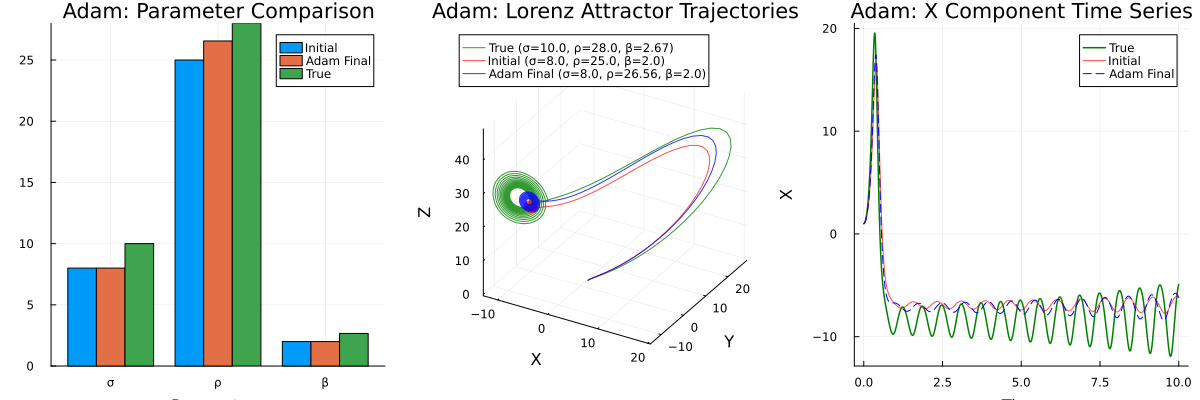

In [49]:
# Plot results comparison for Adam optimizer
println("\nüìä Adam Training Results Visualization")

# Generate trajectories for comparison
initial_sol = integrate(initial_guess, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)
final_sol = integrate(result_adam.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)
true_sol = integrate(params_true, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
param_names = ["œÉ", "œÅ", "Œ≤"]
initial_vals = [initial_guess.œÉ, initial_guess.œÅ, initial_guess.Œ≤]
final_vals = [result_adam.best_params.œÉ, result_adam.best_params.œÅ, result_adam.best_params.Œ≤]
true_vals = [params_true.œÉ, params_true.œÅ, params_true.Œ≤]

p_params = groupedbar([initial_vals final_vals true_vals], 
                      bar_position = :dodge,
                      labels = ["Initial" "Adam Final" "True"],
                      title = "Adam: Parameter Comparison",
                      xlabel = "Parameters", ylabel = "Value",
                      xticks = (1:3, param_names),
                      colors = [:red :blue :green])

# 3D trajectory comparison
p_traj = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
              label="True (œÉ=$(params_true.œÉ), œÅ=$(params_true.œÅ), Œ≤=$(round(params_true.Œ≤, digits=2)))",
              linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial (œÉ=$(initial_guess.œÉ), œÅ=$(initial_guess.œÅ), Œ≤=$(initial_guess.Œ≤))",
      linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj, final_sol.u[:, 1], final_sol.u[:, 2], final_sol.u[:, 3],
      label="Adam Final (œÉ=$(round(result_adam.best_params.œÉ, digits=2)), œÅ=$(round(result_adam.best_params.œÅ, digits=2)), Œ≤=$(round(result_adam.best_params.Œ≤, digits=2)))",
      linecolor=:blue, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj, "Adam: Lorenz Attractor Trajectories")
xlabel!(p_traj, "X"); ylabel!(p_traj, "Y"); zlabel!(p_traj, "Z")

# Time series comparison (X component)
p_time = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time, final_sol.t, final_sol.u[:, 1], label="Adam Final", linecolor=:blue, linewidth=1, linestyle=:dash)
title!(p_time, "Adam: X Component Time Series")
xlabel!(p_time, "Time"); ylabel!(p_time, "X")

plot(p_params, p_traj, p_time, layout=(1,3), size=(1200,400))

In [50]:
# 2. Stochastic Gradient Descent
println("2Ô∏è‚É£ Training with SGD:")
result_sgd = modular_train!(
    initial_guess, target_solution,
    optimizer_config = sgd_config(learning_rate=0.005),
    epochs = 20,
    window_size = 100,
    update_œÉ = false,
    update_œÅ = true,
    update_Œ≤ = false,
    verbose = true

)
println("   SGD result: œÉ=$(round(result_sgd.best_params.œÉ, digits=3)), œÅ=$(round(result_sgd.best_params.œÅ, digits=3)), Œ≤=$(round(result_sgd.best_params.Œ≤, digits=3))")

2Ô∏è‚É£ Training with SGD:
üöÄ Starting modular training with Enzyme gradients
   Optimizer: SGD
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: œÉ=false, œÅ=true, Œ≤=false

Epoch ‚îÇ   Train    ‚îÇ    Val     ‚îÇ      œÉ     ‚îÇ      œÅ     ‚îÇ      Œ≤     ‚îÇ
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
    1 ‚îÇ   4.187953 ‚îÇ   4.556855 ‚îÇ    8.00000 ‚îÇ   25.00408 ‚îÇ    2.00000 ‚îÇ
    2 ‚îÇ   4.184631 ‚îÇ   4.553222 ‚îÇ    8.00000 ‚îÇ   25.00815 ‚îÇ    2.00000 ‚îÇ
    3 ‚îÇ   4.181312 ‚îÇ   4.549590 ‚îÇ    8.00000 ‚îÇ   25.01222 ‚îÇ    2.00000 ‚îÇ
    4 ‚îÇ   4.177997 ‚îÇ   4.545958 ‚îÇ    8.00000 ‚îÇ   25.01629 ‚îÇ    2.00000 ‚îÇ
    5 ‚îÇ   4.174685 ‚îÇ   4.542326 ‚îÇ    8.00000 ‚îÇ   25.02036 ‚îÇ    2.00000 ‚îÇ
    6 ‚îÇ   4.171376 ‚îÇ   4.538695 ‚îÇ    8.00000 ‚îÇ   


üìä Custom Optimizer Training Results Visualization


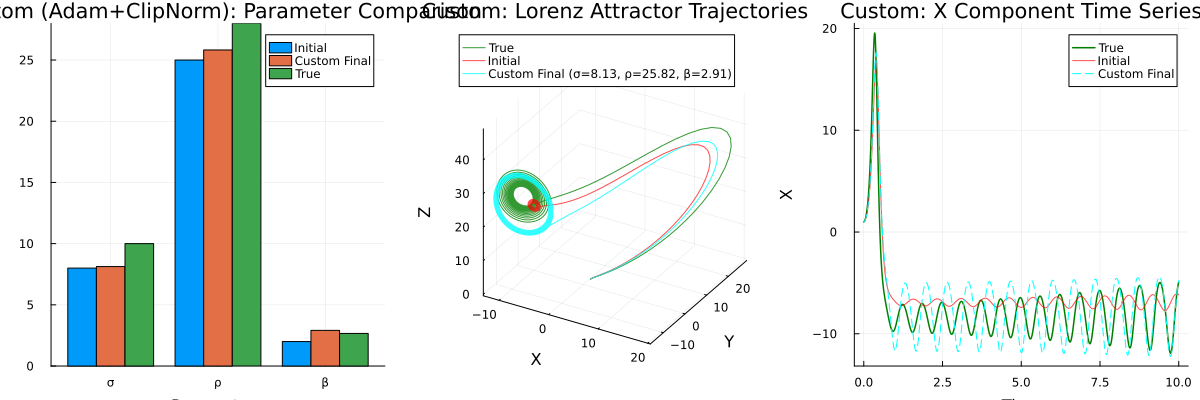

In [51]:
# Plot results comparison for Custom optimizer
println("\nüìä Custom Optimizer Training Results Visualization")

# Generate trajectory for Custom optimizer result
custom_sol = integrate(result_custom.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
custom_vals = [result_custom.best_params.œÉ, result_custom.best_params.œÅ, result_custom.best_params.Œ≤]

p_params_custom = groupedbar([initial_vals custom_vals true_vals], 
                             bar_position = :dodge,
                             labels = ["Initial" "Custom Final" "True"],
                             title = "Custom (Adam+ClipNorm): Parameter Comparison",
                             xlabel = "Parameters", ylabel = "Value",
                             xticks = (1:3, param_names),
                             colors = [:red :cyan :green])

# 3D trajectory comparison
p_traj_custom = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                     label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_custom, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_custom, custom_sol.u[:, 1], custom_sol.u[:, 2], custom_sol.u[:, 3],
      label="Custom Final (œÉ=$(round(result_custom.best_params.œÉ, digits=2)), œÅ=$(round(result_custom.best_params.œÅ, digits=2)), Œ≤=$(round(result_custom.best_params.Œ≤, digits=2)))",
      linecolor=:cyan, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_custom, "Custom: Lorenz Attractor Trajectories")
xlabel!(p_traj_custom, "X"); ylabel!(p_traj_custom, "Y"); zlabel!(p_traj_custom, "Z")

# Time series comparison (X component)
p_time_custom = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_custom, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_custom, custom_sol.t, custom_sol.u[:, 1], label="Custom Final", linecolor=:cyan, linewidth=1, linestyle=:dash)
title!(p_time_custom, "Custom: X Component Time Series")
xlabel!(p_time_custom, "Time"); ylabel!(p_time_custom, "X")

plot(p_params_custom, p_traj_custom, p_time_custom, layout=(1,3), size=(1200,400))

In [52]:
# 3. AdaGrad Optimizer
println("3Ô∏è‚É£ Training with AdaGrad:")
result_adagrad = modular_train!(
    initial_guess, target_solution,
    optimizer_config = adagrad_config(learning_rate=0.1),
    epochs = 100,
    window_size = 100,
    update_œÉ = false,
    update_œÅ = true,
    update_Œ≤ = false,
    verbose = true

)
println("   AdaGrad result: œÉ=$(round(result_adagrad.best_params.œÉ, digits=3)), œÅ=$(round(result_adagrad.best_params.œÅ, digits=3)), Œ≤=$(round(result_adagrad.best_params.Œ≤, digits=3))")

3Ô∏è‚É£ Training with AdaGrad:
üöÄ Starting modular training with Enzyme gradients
   Optimizer: Adagrad
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: œÉ=false, œÅ=true, Œ≤=false

Epoch ‚îÇ   Train    ‚îÇ    Val     ‚îÇ      œÉ     ‚îÇ      œÅ     ‚îÇ      Œ≤     ‚îÇ
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
    1 ‚îÇ   4.030909 ‚îÇ   5.077735 ‚îÇ    8.00000 ‚îÇ   25.08211 ‚îÇ    2.00000 ‚îÇ
    2 ‚îÇ   3.963842 ‚îÇ   5.006311 ‚îÇ    8.00000 ‚îÇ   25.16336 ‚îÇ    2.00000 ‚îÇ
    3 ‚îÇ   3.898163 ‚îÇ   4.935311 ‚îÇ    8.00000 ‚îÇ   25.24376 ‚îÇ    2.00000 ‚îÇ
    4 ‚îÇ   3.833881 ‚îÇ   4.864903 ‚îÇ    8.00000 ‚îÇ   25.32328 ‚îÇ    2.00000 ‚îÇ
    5 ‚îÇ   3.771001 ‚îÇ   4.795241 ‚îÇ    8.00000 ‚îÇ   25.40191 ‚îÇ    2.00000 ‚îÇ
    6 ‚îÇ   3.709531 ‚îÇ   4.726460 ‚îÇ    8.0000

In [53]:
# 4. Custom Optimizer Configuration
println("4Ô∏è‚É£ Training with custom optimizer (Adam + gradient clipping):")
using Optimisers

custom_optimizer = Optimisers.OptimiserChain(
    Optimisers.ClipNorm(1.0),      # Gradient clipping
    Optimisers.Adam(0.01, (0.9, 0.99))  # Adam with custom Œ≤ values
)

# Fix: Use positional arguments for OptimizerConfig constructor
custom_config = OptimizerConfig(
    custom_optimizer,
    0.01,  # learning_rate (positional argument)
    name = "Custom Adam + ClipNorm"
)

result_custom = modular_train!(
    initial_guess, target_solution,
    optimizer_config = custom_config,
    epochs = 100,
    window_size = 100,
    update_œÉ = false,
    update_œÅ = true,
    update_Œ≤ = false,
    verbose = true
)

println("   Custom result: œÉ=$(round(result_custom.best_params.œÉ, digits=3)), œÅ=$(round(result_custom.best_params.œÅ, digits=3)), Œ≤=$(round(result_custom.best_params.Œ≤, digits=3))")


4Ô∏è‚É£ Training with custom optimizer (Adam + gradient clipping):
üöÄ Starting modular training with Enzyme gradients
   Optimizer: Custom Adam + ClipNorm
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: œÉ=false, œÅ=true, Œ≤=false

Epoch ‚îÇ   Train    ‚îÇ    Val     ‚îÇ      œÉ     ‚îÇ      œÅ     ‚îÇ      Œ≤     ‚îÇ
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
    1 ‚îÇ   4.224875 ‚îÇ   4.415157 ‚îÇ    8.00000 ‚îÇ   25.00833 ‚îÇ    2.00000 ‚îÇ
    2 ‚îÇ   4.217942 ‚îÇ   4.408285 ‚îÇ    8.00000 ‚îÇ   25.01665 ‚îÇ    2.00000 ‚îÇ
    3 ‚îÇ   4.211023 ‚îÇ   4.401414 ‚îÇ    8.00000 ‚îÇ   25.02496 ‚îÇ    2.00000 ‚îÇ
    4 ‚îÇ   4.204117 ‚îÇ   4.394545 ‚îÇ    8.00000 ‚îÇ   25.03327 ‚îÇ    2.00000 ‚îÇ
    5 ‚îÇ   4.197224 ‚îÇ   4.387678 ‚îÇ    8.00000 ‚îÇ   25.04156 ‚îÇ    2.00000 ‚î


üìä SGD Training Results Visualization


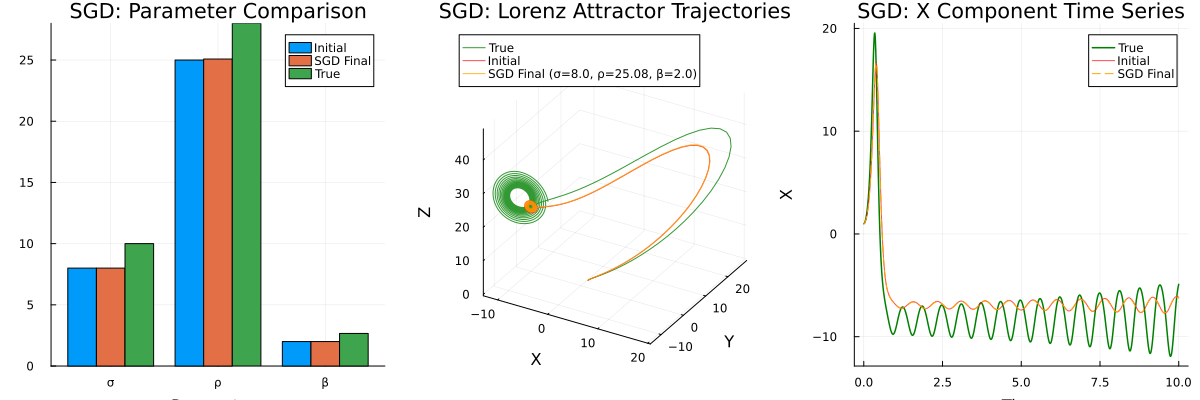

In [54]:
# Plot results comparison for SGD optimizer
println("\nüìä SGD Training Results Visualization")

# Generate trajectory for SGD result
sgd_sol = integrate(result_sgd.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
sgd_vals = [result_sgd.best_params.œÉ, result_sgd.best_params.œÅ, result_sgd.best_params.Œ≤]

p_params_sgd = groupedbar([initial_vals sgd_vals true_vals], 
                          bar_position = :dodge,
                          labels = ["Initial" "SGD Final" "True"],
                          title = "SGD: Parameter Comparison",
                          xlabel = "Parameters", ylabel = "Value",
                          xticks = (1:3, param_names),
                          colors = [:red :orange :green])

# 3D trajectory comparison
p_traj_sgd = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                  label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_sgd, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_sgd, sgd_sol.u[:, 1], sgd_sol.u[:, 2], sgd_sol.u[:, 3],
      label="SGD Final (œÉ=$(round(result_sgd.best_params.œÉ, digits=2)), œÅ=$(round(result_sgd.best_params.œÅ, digits=2)), Œ≤=$(round(result_sgd.best_params.Œ≤, digits=2)))",
      linecolor=:orange, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_sgd, "SGD: Lorenz Attractor Trajectories")
xlabel!(p_traj_sgd, "X"); ylabel!(p_traj_sgd, "Y"); zlabel!(p_traj_sgd, "Z")

# Time series comparison (X component)
p_time_sgd = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_sgd, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_sgd, sgd_sol.t, sgd_sol.u[:, 1], label="SGD Final", linecolor=:orange, linewidth=1, linestyle=:dash)
title!(p_time_sgd, "SGD: X Component Time Series")
xlabel!(p_time_sgd, "Time"); ylabel!(p_time_sgd, "X")

plot(p_params_sgd, p_traj_sgd, p_time_sgd, layout=(1,3), size=(1200,400))

In [55]:
# ========== AVAILABLE OPTIMIZER CONFIGS ==========
println("\n================ Available Optimizer Configurations ================")

# Built-in optimizer configurations (these are convenience functions)
println("üîß Built-in optimizer configs:")
println("   ‚Ä¢ adam_config(learning_rate=0.001)")
println("   ‚Ä¢ sgd_config(learning_rate=0.01)") 
println("   ‚Ä¢ adagrad_config(learning_rate=0.1)")
println("   ‚Ä¢ rmsprop_config(learning_rate=0.001)")

# You can also use any Optimisers.jl optimizer directly
println("\nüõ†Ô∏è  Available Optimisers.jl optimizers:")
println("   ‚Ä¢ Optimisers.Adam(Œ∑, (Œ≤‚ÇÅ, Œ≤‚ÇÇ))")
println("   ‚Ä¢ Optimisers.Descent(Œ∑)  # Plain SGD")
println("   ‚Ä¢ Optimisers.Momentum(Œ∑, œÅ)")
println("   ‚Ä¢ Optimisers.Nesterov(Œ∑, œÅ)")
println("   ‚Ä¢ Optimisers.AdaGrad(Œ∑)")
println("   ‚Ä¢ Optimisers.AdaMax(Œ∑, (Œ≤‚ÇÅ, Œ≤‚ÇÇ))")
println("   ‚Ä¢ Optimisers.RMSProp(Œ∑, œÅ)")
println("   ‚Ä¢ Optimisers.AdaBelief(Œ∑, (Œ≤‚ÇÅ, Œ≤‚ÇÇ))")

# Optimizer chains for combining optimizers
println("\n‚õìÔ∏è  Optimizer chains (combine multiple):")
println("   ‚Ä¢ OptimiserChain(ClipNorm(1.0), Adam(0.001))")
println("   ‚Ä¢ OptimiserChain(ClipGrad(0.5), Momentum(0.01, 0.9))")

println("\nüí° Usage patterns:")
println("   1. Use built-in configs: adam_config(learning_rate=0.01)")
println("   2. Create custom OptimizerConfig with any Optimisers.jl optimizer")
println("   3. Pass directly to modular_train!(optimizer_config=...)")


================ Available Optimizer Configurations ================
üîß Built-in optimizer configs:
   ‚Ä¢ adam_config(learning_rate=0.001)
   ‚Ä¢ sgd_config(learning_rate=0.01)
   ‚Ä¢ adagrad_config(learning_rate=0.1)
   ‚Ä¢ rmsprop_config(learning_rate=0.001)

üõ†Ô∏è  Available Optimisers.jl optimizers:
   ‚Ä¢ Optimisers.Adam(Œ∑, (Œ≤‚ÇÅ, Œ≤‚ÇÇ))
   ‚Ä¢ Optimisers.Descent(Œ∑)  # Plain SGD
   ‚Ä¢ Optimisers.Momentum(Œ∑, œÅ)
   ‚Ä¢ Optimisers.Nesterov(Œ∑, œÅ)
   ‚Ä¢ Optimisers.AdaGrad(Œ∑)
   ‚Ä¢ Optimisers.AdaMax(Œ∑, (Œ≤‚ÇÅ, Œ≤‚ÇÇ))
   ‚Ä¢ Optimisers.RMSProp(Œ∑, œÅ)
   ‚Ä¢ Optimisers.AdaBelief(Œ∑, (Œ≤‚ÇÅ, Œ≤‚ÇÇ))

‚õìÔ∏è  Optimizer chains (combine multiple):
   ‚Ä¢ OptimiserChain(ClipNorm(1.0), Adam(0.001))
   ‚Ä¢ OptimiserChain(ClipGrad(0.5), Momentum(0.01, 0.9))

üí° Usage patterns:
   1. Use built-in configs: adam_config(learning_rate=0.01)
   2. Create custom OptimizerConfig with any Optimisers.jl optimizer
   3. Pass directly to modular_train!(optimizer_config=...)



üìä AdaGrad Training Results Visualization


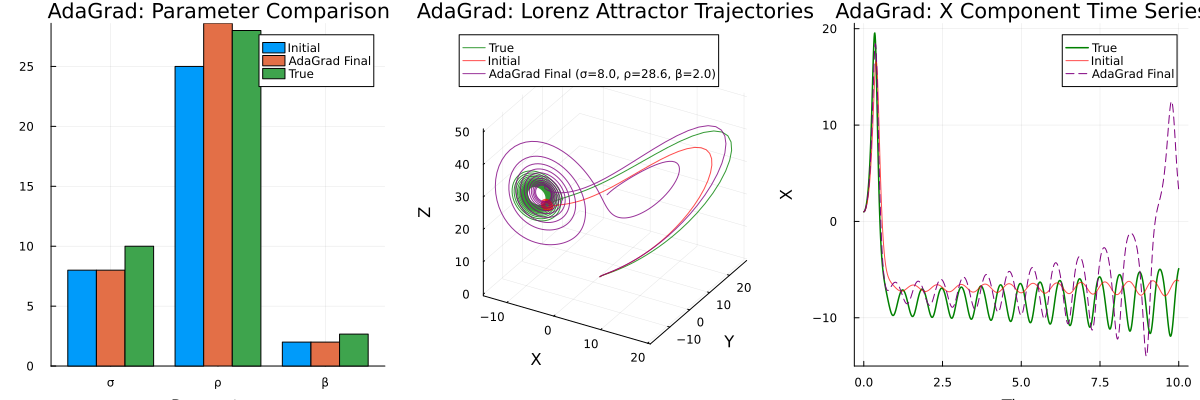

In [56]:
# Plot results comparison for AdaGrad optimizer
println("\nüìä AdaGrad Training Results Visualization")

# Generate trajectory for AdaGrad result
adagrad_sol = integrate(result_adagrad.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
adagrad_vals = [result_adagrad.best_params.œÉ, result_adagrad.best_params.œÅ, result_adagrad.best_params.Œ≤]

p_params_ada = groupedbar([initial_vals adagrad_vals true_vals], 
                          bar_position = :dodge,
                          labels = ["Initial" "AdaGrad Final" "True"],
                          title = "AdaGrad: Parameter Comparison",
                          xlabel = "Parameters", ylabel = "Value",
                          xticks = (1:3, param_names),
                          colors = [:red :purple :green])

# 3D trajectory comparison
p_traj_ada = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                  label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_ada, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_ada, adagrad_sol.u[:, 1], adagrad_sol.u[:, 2], adagrad_sol.u[:, 3],
      label="AdaGrad Final (œÉ=$(round(result_adagrad.best_params.œÉ, digits=2)), œÅ=$(round(result_adagrad.best_params.œÅ, digits=2)), Œ≤=$(round(result_adagrad.best_params.Œ≤, digits=2)))",
      linecolor=:purple, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_ada, "AdaGrad: Lorenz Attractor Trajectories")
xlabel!(p_traj_ada, "X"); ylabel!(p_traj_ada, "Y"); zlabel!(p_traj_ada, "Z")

# Time series comparison (X component)
p_time_ada = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_ada, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_ada, adagrad_sol.t, adagrad_sol.u[:, 1], label="AdaGrad Final", linecolor=:purple, linewidth=1, linestyle=:dash)
title!(p_time_ada, "AdaGrad: X Component Time Series")
xlabel!(p_time_ada, "Time"); ylabel!(p_time_ada, "X")

plot(p_params_ada, p_traj_ada, p_time_ada, layout=(1,3), size=(1200,400))

In [57]:
# ========== COMPREHENSIVE OPTIMIZER COMPARISON ==========
println("\nüèÜ Comprehensive Optimizer Comparison Summary")

# Calculate parameter errors for each optimizer
adam_error = sqrt((result_adam.best_params.œÉ - params_true.œÉ)^2 + 
                  (result_adam.best_params.œÅ - params_true.œÅ)^2 + 
                  (result_adam.best_params.Œ≤ - params_true.Œ≤)^2)

sgd_error = sqrt((result_sgd.best_params.œÉ - params_true.œÉ)^2 + 
                 (result_sgd.best_params.œÅ - params_true.œÅ)^2 + 
                 (result_sgd.best_params.Œ≤ - params_true.Œ≤)^2)

adagrad_error = sqrt((result_adagrad.best_params.œÉ - params_true.œÉ)^2 + 
                     (result_adagrad.best_params.œÅ - params_true.œÅ)^2 + 
                     (result_adagrad.best_params.Œ≤ - params_true.Œ≤)^2)

custom_error = sqrt((result_custom.best_params.œÉ - params_true.œÉ)^2 + 
                    (result_custom.best_params.œÅ - params_true.œÅ)^2 + 
                    (result_custom.best_params.Œ≤ - params_true.Œ≤)^2)

initial_error = sqrt((initial_guess.œÉ - params_true.œÉ)^2 + 
                     (initial_guess.œÅ - params_true.œÅ)^2 + 
                     (initial_guess.Œ≤ - params_true.Œ≤)^2)

# All optimizer results for comparison
all_results = [initial_vals adam_vals sgd_vals adagrad_vals custom_vals true_vals]
optimizer_names = ["Initial", "Adam", "SGD", "AdaGrad", "Custom", "True"]
colors_all = [:red :blue :orange :purple :cyan :green]

# Parameter comparison across all optimizers
p_all_params = groupedbar(all_results, 
                          bar_position = :dodge,
                          labels = permutedims(optimizer_names),
                          title = "All Optimizers: Parameter Comparison",
                          xlabel = "Parameters", ylabel = "Value",
                          xticks = (1:3, param_names),
                          colors = permutedims(colors_all))

# Error comparison bar chart
errors = [initial_error, adam_error, sgd_error, adagrad_error, custom_error]
error_names = ["Initial", "Adam", "SGD", "AdaGrad", "Custom"]
p_errors = bar(error_names, errors, 
               title = "Parameter Error (L2 norm from true)",
               ylabel = "Error", xlabel = "Optimizer",
               color = [:red :blue :orange :purple :cyan],
               legend = false)

# Performance summary table
println("\nüìà Optimizer Performance Summary:")
println("‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê")
println("‚îÇ  Optimizer  ‚îÇ    œÉ     ‚îÇ    œÅ     ‚îÇ    Œ≤     ‚îÇ Total Error ‚îÇ")
println("‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§")
@printf("‚îÇ Initial     ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %11.6f ‚îÇ\n", initial_guess.œÉ, initial_guess.œÅ, initial_guess.Œ≤, initial_error)
@printf("‚îÇ Adam        ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %11.6f ‚îÇ\n", result_adam.best_params.œÉ, result_adam.best_params.œÅ, result_adam.best_params.Œ≤, adam_error)
@printf("‚îÇ SGD         ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %11.6f ‚îÇ\n", result_sgd.best_params.œÉ, result_sgd.best_params.œÅ, result_sgd.best_params.Œ≤, sgd_error)
@printf("‚îÇ AdaGrad     ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %11.6f ‚îÇ\n", result_adagrad.best_params.œÉ, result_adagrad.best_params.œÅ, result_adagrad.best_params.Œ≤, adagrad_error)
@printf("‚îÇ Custom      ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %11.6f ‚îÇ\n", result_custom.best_params.œÉ, result_custom.best_params.œÅ, result_custom.best_params.Œ≤, custom_error)
@printf("‚îÇ True        ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %8.3f ‚îÇ %11.6f ‚îÇ\n", params_true.œÉ, params_true.œÅ, params_true.Œ≤, 0.0)
println("‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò")

# Find best optimizer
best_idx = argmin([adam_error, sgd_error, adagrad_error, custom_error])
best_names = ["Adam", "SGD", "AdaGrad", "Custom"]
println("\nüéØ Best performer: $(best_names[best_idx]) with error $(round(minimum([adam_error, sgd_error, adagrad_error, custom_error]), digits=6))")

plot(p_all_params, p_errors, layout=(1,2), size=(1000,400))


üèÜ Comprehensive Optimizer Comparison Summary


UndefVarError: UndefVarError: `adam_vals` not defined in `Main`
Suggestion: check for spelling errors or missing imports.